In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
import cv2

In [2]:
class Metrics:
    def __init__(self):
        self.acc = 0
        self.sensitivity = 0
        self.specificity = 0
        self.f1 = 0
        
    def calculate(self, y_true, y_pred):
        tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
        
        self.acc = metrics.accuracy_score(y_true, y_pred)
        self.sensitivity = tp = tp / (tp + fn)
        self.specificity = tn / (tn + fp)
        self.f1 = metrics.f1_score(y_true, y_pred)
        
    def __str__(self):
        return 'Acc: {:.5f}, sensitivity: {:.5f}, specificity: {:.5f}, F1-score: {:.5f}'.format(
            self.acc, self.sensitivity, self.specificity, self.f1)
    
    @staticmethod
    def mean_metric(scores_all):
        """ Calculates mean metrics for samples """
        res = Metrics()
        
        for metric in scores_all:
            res.acc += metric.acc / len(scores_all)
            res.sensitivity += metric.sensitivity / len(scores_all)
            res.specificity += metric.specificity / len(scores_all)
            res.f1 += metric.f1 / len(scores_all)
            
        return res

In [3]:
DATA_PATH = 'data/'
X_IMG_PATH = DATA_PATH + 'images/'
Y_IMG_PATH = DATA_PATH + 'labels/'

THRESHOLD_LABELS_POS = .5
THRESHOLD_PRED_POS = 10
MASK_COLOR_RGB = (60, 255, 0)

In [4]:
def load_img(path):
    """ Loads and returns image in RGB color model """
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

In [5]:
def process_train(path):
    """ Perform train image processing
    
    Removes background, performs some preprocessing operations
    and applies Canny edge detector.
    """
    img = load_img(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Find background of image
    th, threshed = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    cnts = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnts = sorted(cnts, key=cv2.contourArea)

    # Create mask of the background
    mask = np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask, cnts, -1, 255, -1)
    dst = cv2.bitwise_and(img_gray, img_gray, mask=mask)
    
    # Perform dilation in order to remove background artefacts
    kernel9 = np.ones((9, 9), np.uint8)
    dst = cv2.dilate(dst, kernel9, iterations=1)
    mask_out = (dst == 0)
    
    kernel3 = np.ones((3, 3), np.uint8)
    
    # Perform Canny edge detection
    edges = cv2.Canny(img_gray, 20, 100)
    edges_eroded = cv2.dilate(edges, kernel3, iterations=1)
    
    # Remove background from an image and cut off uncertain pixels
    edges_eroded = edges_eroded * mask_out
    edges_offset = edges_eroded > THRESHOLD_PRED_POS
    
    return edges_offset

def process_label(path):
    """ Process label image
    
    Loads image and applies threshold on uncertain pixels.
    """
    img = load_img(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = img_gray > THRESHOLD_LABELS_POS
    return mask

In [6]:
filenames = os.listdir(X_IMG_PATH)
images_orig = [load_img(X_IMG_PATH + fname) for fname in filenames]

In [7]:
def apply_mask_with_color(img, mask):
    """ Applies colored mask on original image """
    img = img.copy()
    img[mask] = MASK_COLOR_RGB
    return img

In [8]:
y_preds, y_trues = [], []
scores_all = []

for fname in filenames:
    y_pred = process_train(X_IMG_PATH + fname)
    y_true = process_label(Y_IMG_PATH + fname)
    
    scores = Metrics()
    scores.calculate(y_true.ravel(), y_pred.ravel())
    
    y_preds.append(y_pred)
    y_trues.append(y_true)
    scores_all.append(scores)
    
    print(fname, scores)

im0162.ppm Acc: 0.90857, sensitivity: 0.67691, specificity: 0.92634, F1-score: 0.51342
im0139.ppm Acc: 0.91703, sensitivity: 0.17541, specificity: 0.98188, F1-score: 0.25375
im0235.ppm Acc: 0.91044, sensitivity: 0.37667, specificity: 0.96260, F1-score: 0.42818
im0255.ppm Acc: 0.90191, sensitivity: 0.65541, specificity: 0.92614, F1-score: 0.54463
im0004.ppm Acc: 0.92567, sensitivity: 0.00025, specificity: 0.99977, F1-score: 0.00051
im0044.ppm Acc: 0.90459, sensitivity: 0.46166, specificity: 0.93775, F1-score: 0.40263
im0001.ppm Acc: 0.89542, sensitivity: 0.05935, specificity: 0.96793, F1-score: 0.08306
im0081.ppm Acc: 0.91298, sensitivity: 0.37897, specificity: 0.95606, F1-score: 0.39400
im0163.ppm Acc: 0.92191, sensitivity: 0.63745, specificity: 0.94576, F1-score: 0.55804
im0291.ppm Acc: 0.95187, sensitivity: 0.25525, specificity: 0.98898, F1-score: 0.34914
im0082.ppm Acc: 0.90607, sensitivity: 0.57238, specificity: 0.93456, F1-score: 0.48944
im0240.ppm Acc: 0.89793, sensitivity: 0.029

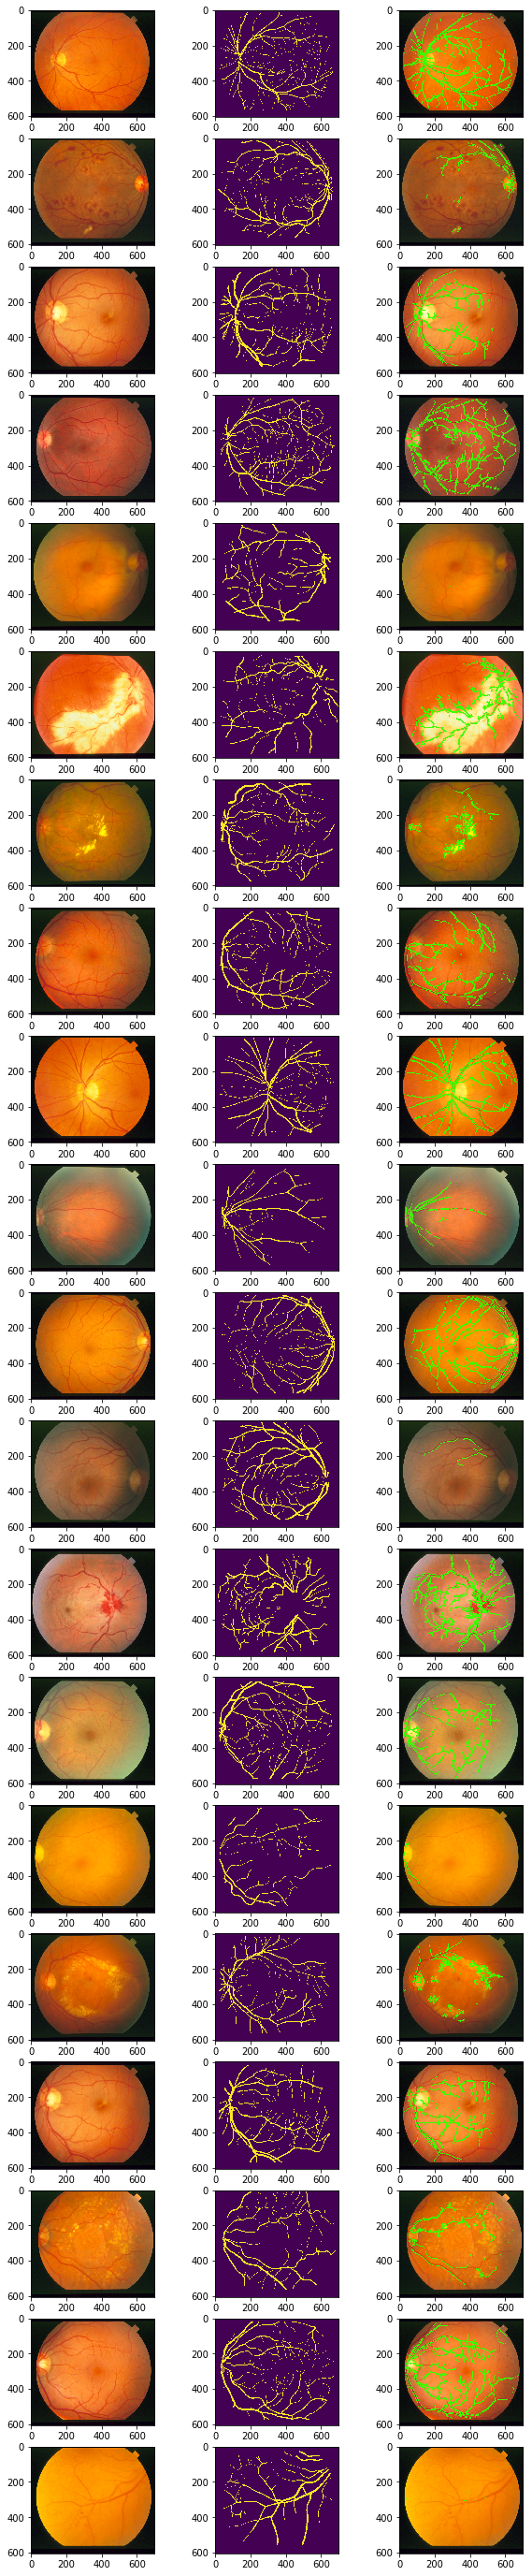

In [9]:
fig = plt.figure(figsize=(10, 50))
cols, rows = 3, len(filenames)

for i in range(rows):
    fig.add_subplot(rows, cols, cols*i + 1)
    plt.imshow(images_orig[i], aspect='equal')
    
    fig.add_subplot(rows, cols, cols*i + 2)
    plt.imshow(y_trues[i], aspect='equal')
    
    fig.add_subplot(rows, cols, cols*i + 3)
    y_pred_mask = apply_mask_with_color(images_orig[i], y_preds[i])
    plt.imshow(y_pred_mask, aspect='equal')

In [10]:
metrics_overview = Metrics.mean_metric(scores_all)
print('Mean metrics for {} samples:'.format(len(filenames)))
print(metrics_overview)

Mean metrics for 20 samples:
Acc: 0.91412, sensitivity: 0.32647, specificity: 0.96143, F1-score: 0.31779
